In [28]:
import scipy.io
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from scipy.linalg import norm

from tqdm.keras import TqdmCallback
from tqdm import tqdm
from tensorflow.keras.callbacks import EarlyStopping

from itertools import product
from random import shuffle

from plot_keras_history import plot_history
import matplotlib.pyplot as plt

# import keras_tuner as kt
from keras.models import load_model

import matplotlib
from os.path import exists

from sklearn.metrics import mean_squared_error
import numpy as np

import seaborn as sns
import pandas as pd

from tensorflow.keras.models import load_model




np.random.seed(10)

In [29]:
clients = [1, 2, 3]
epochs = 15

In [30]:
data = scipy.io.loadmat("data.mat")

trainData = data["trainData"].transpose((3, 0, 1, 2))
trainLabels = data["trainLabels"].transpose((3, 0, 1, 2))
valData = data["valData"].transpose((3, 0, 1, 2))
valLabels = data["valLabels"].transpose((3, 0, 1, 2))

In [31]:
import scipy.io
import numpy as np

# Load the data from the .mat file
data = scipy.io.loadmat("data.mat")
trainData = data["trainData"].transpose((3, 0, 1, 2))
trainLabels = data["trainLabels"].transpose((3, 0, 1, 2))
valData = data["valData"].transpose((3, 0, 1, 2))
valLabels = data["valLabels"].transpose((3, 0, 1, 2))

# Determine the number of clients
clients = [1, 2, 3]  # Example: 3 clients

# Generate a random permutation of indices
num_samples = len(trainData)
permutation = np.random.permutation(num_samples)

# Shuffle the training data and labels using the same permutation
shuffled_trainData = trainData[permutation]
shuffled_trainLabels = trainLabels[permutation]

# Split the shuffled training data into parts for each client
n_parts = len(clients)
part_size = len(shuffled_trainData) // n_parts
dataset_parts = []
for i in range(n_parts):
    start = i * part_size
    end = (i + 1) * part_size
    X_part = shuffled_trainData[start:end]
    y_part = shuffled_trainLabels[start:end]
    dataset_parts.append((X_part, y_part))

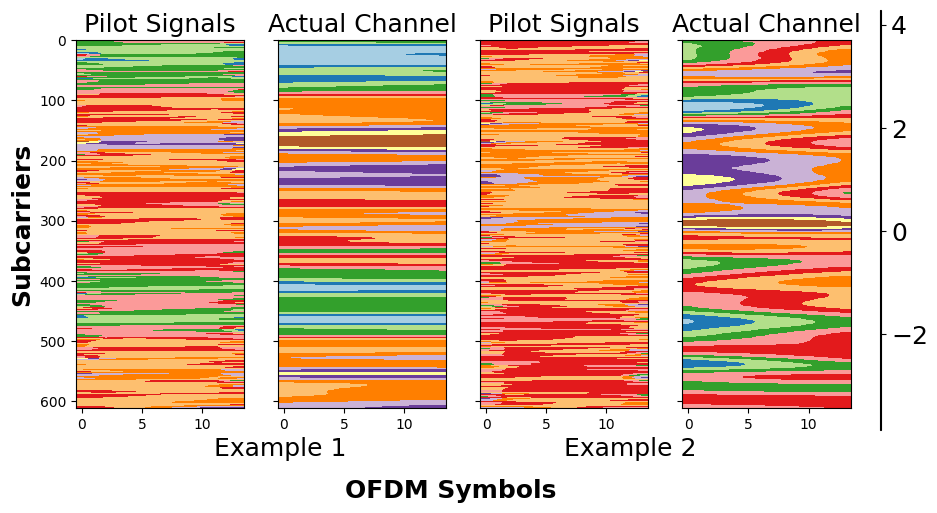

In [32]:
cmap_name = "Paired"
font_size = 18

rand_idx = np.random.randint(0, valData.shape[0], 2)

test_input1 = valData[rand_idx[0] : rand_idx[0] + 1, :]
real_output1 = valLabels[rand_idx[0] : rand_idx[0] + 1, :]

test_input2 = valData[rand_idx[1] : rand_idx[1] + 1, :]
real_output2 = valLabels[rand_idx[1] : rand_idx[1] + 1, :]

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 6), sharey=True)

im1 = ax[0].imshow(test_input1.reshape(612, 14), cmap=cmap_name)
ax[0].set_aspect(0.05)
ax[0].set_title("Pilot Signals", fontsize=font_size)

ax[1].imshow(real_output1.reshape(612, 14), cmap=cmap_name)
ax[1].set_aspect(0.05)
ax[1].set_title("Actual Channel", fontsize=font_size)

im1 = ax[2].imshow(test_input2.reshape(612, 14), cmap=cmap_name)
ax[2].set_aspect(0.05)
ax[2].set_title("Pilot Signals", fontsize=font_size)

ax[3].imshow(real_output2.reshape(612, 14), cmap=cmap_name)
ax[3].set_aspect(0.05)
ax[3].set_title("Actual Channel", fontsize=font_size)

ax[0].set_ylabel("Subcarriers", fontsize=font_size, fontweight="bold")
fig.text(
    0.5,
    0.05,
    "OFDM Symbols",
    ha="center",
    va="center",
    fontsize=font_size,
    fontweight="bold",
)
fig.text(
    0.33,
    0.12,
    "Example 1",
    ha="center",
    va="center",
    fontsize=font_size,
    fontweight="normal",
)
fig.text(
    0.68,
    0.12,
    "Example 2",
    ha="center",
    va="center",
    fontsize=font_size,
    fontweight="normal",
)

cbar_ax = fig.add_axes([0.92, 0.152, 0.02, 0.7])
fig.colorbar(im1, cax=cbar_ax)
cbar_ax.set_aspect(50.5)
cbar_ax.tick_params(labelsize=font_size)

# plt.show()

In [33]:
def get_model(mult_factor=1.0, model_name=""):
    model = models.Sequential(name=model_name)
    # selu, softplus, selu
    model.add(
        layers.Conv2D(
            int(48 * mult_factor),
            (9, 9),
            padding="same",
            activation="selu",
            input_shape=(612, 14, 1),
        )
    )
    model.add(
        layers.Conv2D(
            int(16 * mult_factor), (5, 5), padding="same", activation="softplus"
        )
    )
    model.add(layers.Conv2D(1, (5, 5), padding="same", activation="selu"))
    model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
    return model

In [34]:
# model = get_model(1.0, model_name="FL-model")

# es_teacher = EarlyStopping(
#     monitor="val_loss", patience=50, verbose=1, restore_best_weights=True, mode="min"
# )

# model.compile(optimizer="adam", loss="mse", metrics=["mse"])
# # Train and evaluate teacher on data.

# hist_model = model.fit(
#     trainData,
#     trainLabels,
#     epochs=10,
#     verbose=0,
#     batch_size=128,
#     callbacks=[es_teacher, TqdmCallback(verbose=1, desc="DL training")],
#     validation_data=(valData, valLabels),
# )

In [35]:
allmodels = []
for _ in range(len(clients)):
    allmodels.append(get_model())

In [36]:
import numpy as np
from Pyfhel import Pyfhel

HE = Pyfhel()  # Creating empty Pyfhel object
ckks_params = {
    "scheme": "CKKS",  # can also be 'ckks'
    "n": 2**14,  # Polynomial modulus degree. For CKKS, n/2 values can be
    #  encoded in a single ciphertext.
    #  Typ. 2^D for D in [10, 15]
    "scale": 2**30,  # All the encodings will use it for float->fixed point
    #  conversion: x_fix = round(x_float * scale)
    #  You can use this as default scale or use a different
    #  scale on each operation (set in HE.encryptFrac)
    "qi_sizes": [60, 30, 30, 30, 60],  # Number of bits of each prime in the chain.
    # Intermediate values should be  close to log2(scale)
    # for each operation, to have small rounding errors.
}
HE.contextGen(**ckks_params)  # Generate context for ckks scheme
HE.keyGen()  # Key Generation: generates a pair of public/secret keys
HE.rotateKeyGen()

In [37]:
def encrypt_wt(wtarray):
    cwt = []
    for layer in wtarray:
        flat_array = layer.astype(np.float64).flatten()

        chunks = np.array_split(flat_array, (len(flat_array) + 2**10 - 1) // 2**10)
        clayer = []
        for chunk in chunks:
            ptxt = HE.encodeFrac(chunk)
            ctxt = HE.encryptPtxt(ptxt)
            clayer.append(ctxt)
        cwt.append(clayer.copy())
    return cwt

In [38]:
def aggregate_wt(cwts):
    resmodel = []
    for j in range(len(cwts[0])):  # for layers
        layer = []
        for k in range(len(cwts[0][j])):  # for chunks
            tmp = cwts[0][j][k].copy()
            for i in range(1, len(cwts)):  # for clients
                tmp = tmp + cwts[i][j][k]
            tmp = tmp / len(cwts)
            layer.append(tmp)
        resmodel.append(layer)

    res = [resmodel.copy() for _ in range(len(clients))]
    return res

In [39]:
def decrypt_weights(res):
    decrypted_weights = []
    for client_weights, model in zip(res, allmodels):
        decrypted_client_weights = []
        wtarray = model.get_weights()
        for layer_weights, layer in zip(client_weights, wtarray):
            decrypted_layer_weights = []
            flat_array = layer.astype(np.float64).flatten()
            chunks = np.array_split(flat_array, (len(flat_array) + 2**10 - 1) // 2**10)
            for chunk, encrypted_chunk in zip(chunks, layer_weights):
                decrypted_chunk = HE.decryptFrac(encrypted_chunk)
                original_chunk_size = len(chunk)
                decrypted_chunk = decrypted_chunk[:original_chunk_size]
                decrypted_layer_weights.append(decrypted_chunk)
            decrypted_layer_weights = np.concatenate(decrypted_layer_weights, axis=0)
            decrypted_layer_weights = decrypted_layer_weights.reshape(layer.shape)
            decrypted_client_weights.append(decrypted_layer_weights)
        decrypted_weights.append(decrypted_client_weights)
    return decrypted_weights

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# ... (previous code remains the same)

cwts = [encrypt_wt(model.get_weights()) for model in allmodels]
aggregate_loss = []  # Store the loss values of the aggregated model
aggregate_accuracy = []  # Store the accuracy values of the aggregated model
client_loss = {
    client: [] for client in clients
}  # Store the loss values for each client
client_accuracy = {
    client: [] for client in clients
}  # Store the accuracy values for each client

for e in tqdm(range(epochs)):
    wts = decrypt_weights(cwts)
    cwts = []

    # Evaluate the loss and accuracy of the aggregated model before fitting
    aggregated_model = get_model()
    aggregated_model.set_weights(wts[0])  # Set the weights of the aggregated model
    loss, accuracy = aggregated_model.evaluate(valData, valLabels, verbose=0)
    aggregate_loss.append(loss)
    aggregate_accuracy.append(accuracy)

    for wt, m, dataset, client in zip(wts, allmodels, dataset_parts, clients):
        m.set_weights(wt)
        history = m.fit(dataset[0], dataset[1], epochs=1, verbose=0)
        loss, accuracy = m.evaluate(valData, valLabels)
        client_loss[client].append(loss)
        client_accuracy[client].append(accuracy)
        wtarray = m.get_weights()
        cwts.append(encrypt_wt(wtarray))

    cwts = aggregate_wt(cwts)

# Plot the loss and accuracy of the aggregated model and individual models
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
epochs_range = range(1, epochs + 1)

# Plot loss
ax1.plot(
    epochs_range, aggregate_loss, label="Aggregated Model", linewidth=2, marker="o"
)
for client, loss_values in client_loss.items():
    ax1.plot(
        epochs_range, loss_values, label=f"Client {client}", linewidth=2, marker="o"
    )
ax1.set_xlabel("Epoch", fontsize=14)
ax1.set_ylabel("Loss", fontsize=14)
ax1.set_title("Loss", fontsize=16)
ax1.legend(fontsize=12)
ax1.grid(True)

# Plot accuracy
ax2.plot(
    epochs_range, aggregate_accuracy, label="Aggregated Model", linewidth=2, marker="o"
)
for client, accuracy_values in client_accuracy.items():
    ax2.plot(
        epochs_range, accuracy_values, label=f"Client {client}", linewidth=2, marker="o"
    )
ax2.set_xlabel("Epoch", fontsize=14)
ax2.set_ylabel("Accuracy", fontsize=14)
ax2.set_title("Accuracy", fontsize=16)
ax2.legend(fontsize=12)
ax2.grid(True)

plt.tight_layout()
plt.show()

  0%|          | 0/15 [00:00<?, ?it/s]

1/1 [==============================] - 0s 142ms/step - loss: 0.1080 - accuracy: 0.0000e+00


  7%|▋         | 1/15 [00:13<03:14, 13.91s/it]

1/1 [==============================] - 0s 91ms/step - loss: 0.1232 - accuracy: 0.0000e+00


  7%|▋         | 1/15 [00:20<04:42, 20.16s/it]


KeyboardInterrupt: 

1/1 [==============================] - 0s 36ms/step


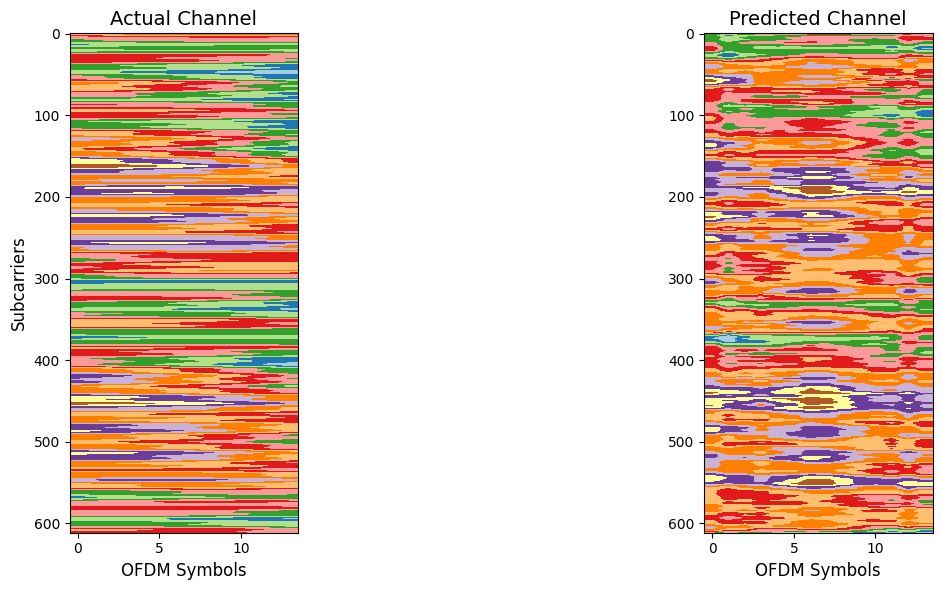

In [ ]:
# Plot predicted vs. actual channel
rand_idx = np.random.randint(0, valData.shape[0])
test_input = valData[rand_idx : rand_idx + 1, :]
real_output = valLabels[rand_idx : rand_idx + 1, :]

predicted_output = aggregated_model.predict(test_input)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
im1 = ax[0].imshow(real_output.reshape(612, 14), cmap="Paired")
ax[0].set_aspect(0.05)
ax[0].set_title("Actual Channel", fontsize=14)
ax[0].set_ylabel("Subcarriers", fontsize=12)
ax[0].set_xlabel("OFDM Symbols", fontsize=12)

im2 = ax[1].imshow(predicted_output.reshape(612, 14), cmap="Paired")
ax[1].set_aspect(0.05)
ax[1].set_title("Predicted Channel", fontsize=14)
ax[1].set_xlabel("OFDM Symbols", fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
# Calculate client-wise performance metrics
for client in clients:
    client_model = get_model()
    client_model.set_weights(wts[client - 1])
    loss, accuracy = client_model.evaluate(valData, valLabels, verbose=0)
    print(f"Client {client} - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

Client 1 - Loss: 0.0422, Accuracy: 0.0000
Client 2 - Loss: 0.0422, Accuracy: 0.0000
Client 3 - Loss: 0.0422, Accuracy: 0.0000


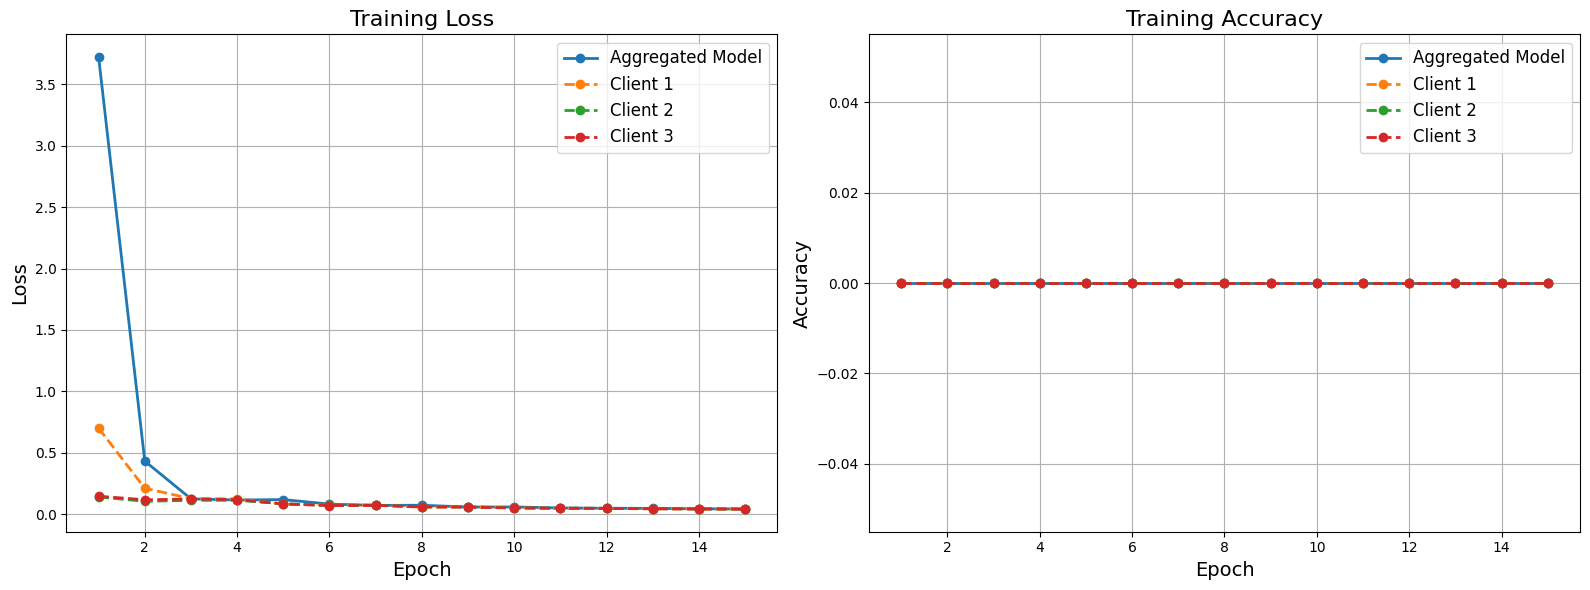

In [ ]:
# Plot training progress
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
epochs_range = range(1, epochs + 1)

# Plot loss
ax1.plot(
    epochs_range, aggregate_loss, label="Aggregated Model", linewidth=2, marker="o"
)
for client, loss_values in client_loss.items():
    ax1.plot(
        epochs_range,
        loss_values,
        label=f"Client {client}",
        linewidth=2,
        linestyle="--",
        marker="o",
    )
ax1.set_xlabel("Epoch", fontsize=14)
ax1.set_ylabel("Loss", fontsize=14)
ax1.set_title("Training Loss", fontsize=16)
ax1.legend(fontsize=12)
ax1.grid(True)

# Plot accuracy
ax2.plot(
    epochs_range, aggregate_accuracy, label="Aggregated Model", linewidth=2, marker="o"
)
for client, accuracy_values in client_accuracy.items():
    ax2.plot(
        epochs_range,
        accuracy_values,
        label=f"Client {client}",
        linewidth=2,
        linestyle="--",
        marker="o",
    )
ax2.set_xlabel("Epoch", fontsize=14)
ax2.set_ylabel("Accuracy", fontsize=14)
ax2.set_title("Training Accuracy", fontsize=16)
ax2.legend(fontsize=12)
ax2.grid(True)

plt.tight_layout()
plt.show()

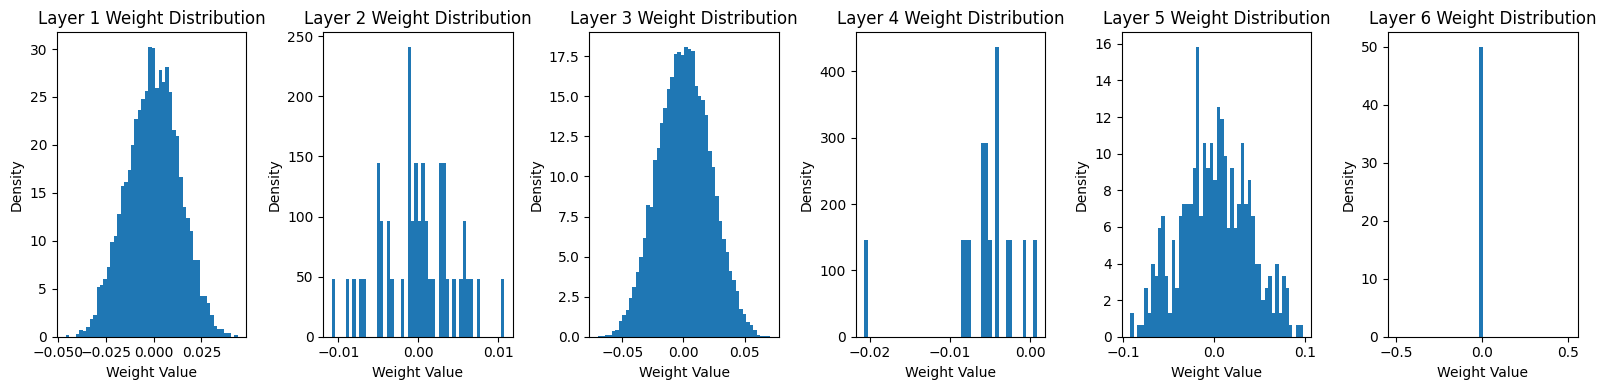

In [ ]:
# Plot weight distribution
num_layers = len(wts[0])
fig, axes = plt.subplots(1, num_layers, figsize=(16, 4))
for i in range(num_layers):
    layer_weights = wts[0][i].flatten()
    axes[i].hist(layer_weights, bins=50, density=True)
    axes[i].set_title(f"Layer {i+1} Weight Distribution", fontsize=12)
    axes[i].set_xlabel("Weight Value", fontsize=10)
    axes[i].set_ylabel("Density", fontsize=10)
plt.tight_layout()
plt.show()

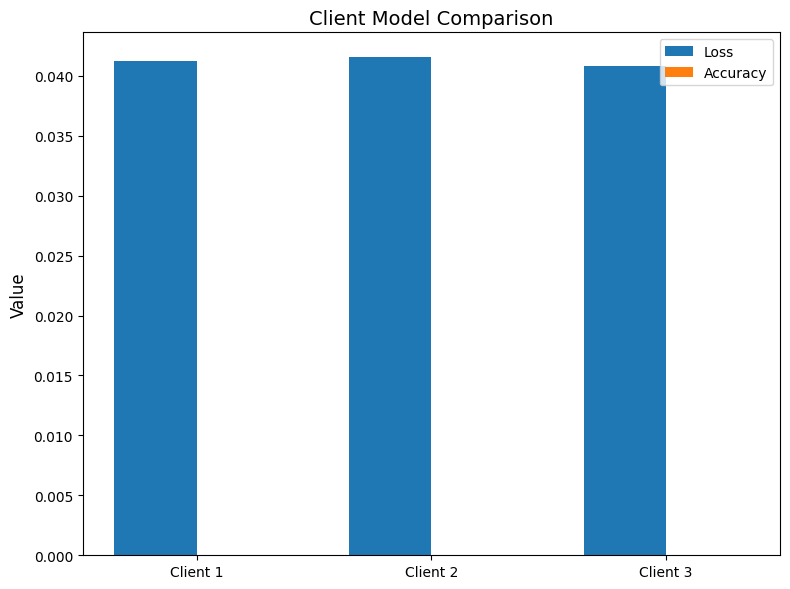

In [ ]:
# Compare client models
fig, ax = plt.subplots(figsize=(8, 6))
x = np.arange(len(clients))
width = 0.35
loss_values = [client_loss[client][-1] for client in clients]
accuracy_values = [client_accuracy[client][-1] for client in clients]
rects1 = ax.bar(x - width / 2, loss_values, width, label="Loss")
rects2 = ax.bar(x + width / 2, accuracy_values, width, label="Accuracy")
ax.set_xticks(x)
ax.set_xticklabels([f"Client {client}" for client in clients])
ax.set_ylabel("Value", fontsize=12)
ax.set_title("Client Model Comparison", fontsize=14)
ax.legend(fontsize=10)
plt.tight_layout()
plt.show()

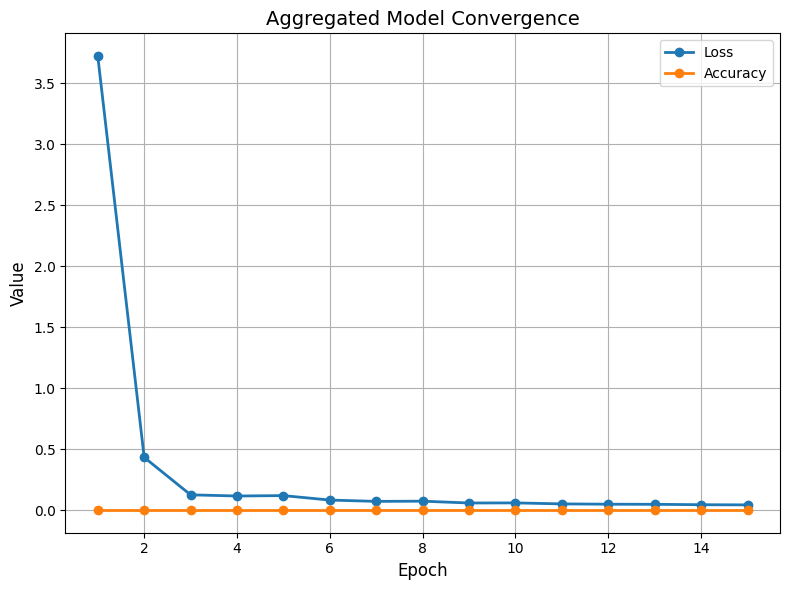

In [ ]:
# Plot aggregated model convergence
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(epochs_range, aggregate_loss, label="Loss", linewidth=2, marker="o")
ax.plot(epochs_range, aggregate_accuracy, label="Accuracy", linewidth=2, marker="o")
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Value", fontsize=12)
ax.set_title("Aggregated Model Convergence", fontsize=14)
ax.legend(fontsize=10)
ax.grid(True)
plt.tight_layout()
plt.show()